# CLIMATE CHANGE TWEET CLASSIFICATION

# Lumina Datamatics

### Team Members
Abidence

Ayanda

Emmanuel 

Mathapelo

Mpho

Nyiko

Tshepo

Importing the libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
# Style
import plotly.express as px
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

In [5]:
# Downloads
#nlp = spacy.load('en')
nlp = spacy.blank('en')
nlp = spacy.blank('zh')
nlp = spacy.blank('xx') # multilanguage (spaCy provides support for languages) 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\climate.intern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\climate.intern\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\climate.intern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\climate.intern\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [7]:
# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [8]:
from powerbiclient import Report, models
from io import StringIO
from ipywidgets import interact
import requests
from PIL import Image

Loading the data

In [9]:
train_df = pd.read_csv(r'C:\Users\climate.intern\OneDrive - MSF\Documents\GitHub\classification-predict-streamlit-template\train.csv')
test_df = pd.read_csv(r'C:\Users\climate.intern\OneDrive - MSF\Documents\GitHub\classification-predict-streamlit-template\test_with_no_labels.csv')

### Description of the data

In [10]:
train_df.head() 

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [11]:
print(train_df.shape)
print(test_df.shape)

display(train_df.head())
display(test_df.head())

(15819, 3)
(10546, 2)


sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \r\nPu...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

The datasets aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018.

The train data is structured as:
* sentiment: Sentiment of tweet i.e 0, 1, etc
* message: Tweet body
* tweetid: Twitter unique id

The sentiments of the test data is the prediction target

#### Data Dimensions and Completeness

In [14]:
train_df['sentiment'].unique() 

array([ 1,  2,  0, -1], dtype=int64)

Sentiment Description:
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate chang

In [15]:
train_df["sentiment"].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

8530 tweets are believe, 3640 tweets are factual news about climate change, 2353 neither support nor refutes, and 1296 tweets do not believe in climate change

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


#### Checking for missing values

In [19]:
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [20]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

Both the train and test datasets are complete, without null values.

In [12]:
# Looking for duplicates
percent_duplicates = round((1-(train_df['message'].nunique()/len(train_df['message'])))*100,2)
print('Duplicated tweets in train data:')
print(percent_duplicates,'%')

Duplicated tweets in train data:
10.05 %


## Exploratory Data Analysis 

In [22]:
def update(df):

    df = train_df.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        elif i == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')

    df['sentiment'] = word_sentiment
    
    return df

df = update(train_df)
df.head()

sentiment                                            message  tweetid
0       Pro  PolySciMajor EPA chief doesn't think carbon di...   625221
1       Pro  It's not like we lack evidence of anthropogeni...   126103
2      News  RT @RawStory: Researchers say we have three ye...   698562
3       Pro  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4       Pro  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

### Target variable distribution

C:\Users\climate.intern\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\climate.intern\AppData\Local\Temp\ipykernel_2936\1894648908.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


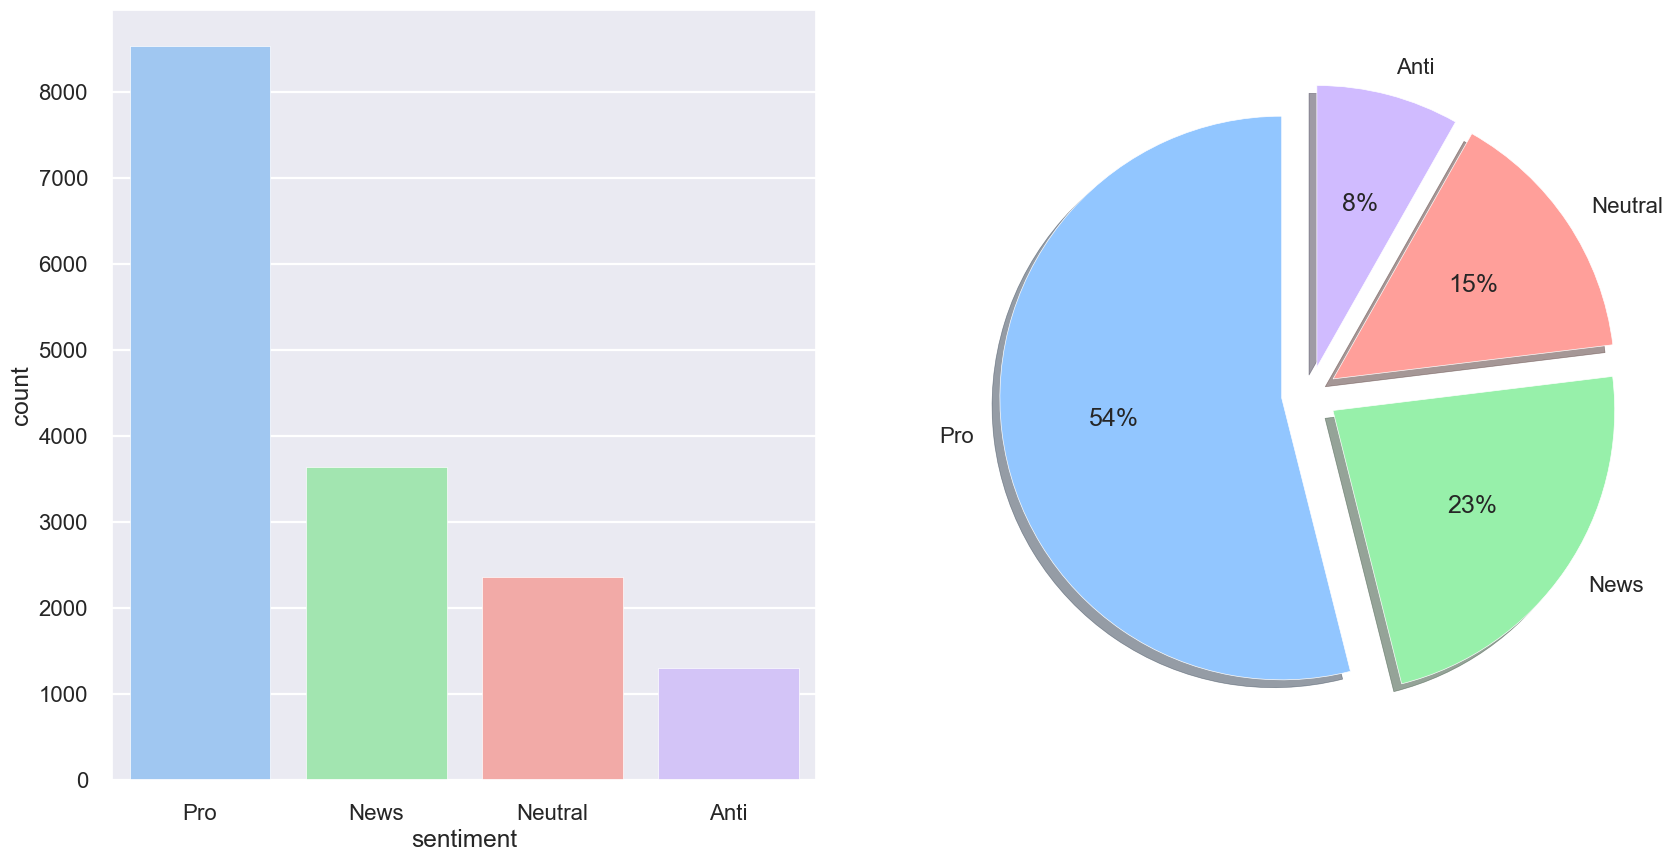

In [23]:
# Display target distribution
style.use('seaborn-pastel')

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(df['sentiment'], ax=axes[0])

labels=['Pro', 'News', 'Neutral', 'Anti'] 

axes[1].pie(df['sentiment'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.show()

#### Sentiments
54% of the data is positive reaction to climate change, whilst negative reactions amount to 8%. News account for 23% of the data, neutral tweets are 15%. 

Taking a closer look at the distribution of the tweets we notice that the data is severely imbalanced with the majority of tweets falling in the 'pro' category, supporting the belief of man-made climate change.

In [28]:
fig = px.funnel(temp, x='sentiment', y='message',color='sentiment')
fig.show()

The funnel chart paints a clearer picture of the distribution of tweets and reveals that the train dataset is imbalanced. This imbalance will be dealt with at the later stage of modeling

#### Tweet length distribution 

In [31]:
df['length'] = df['message'].apply(len)


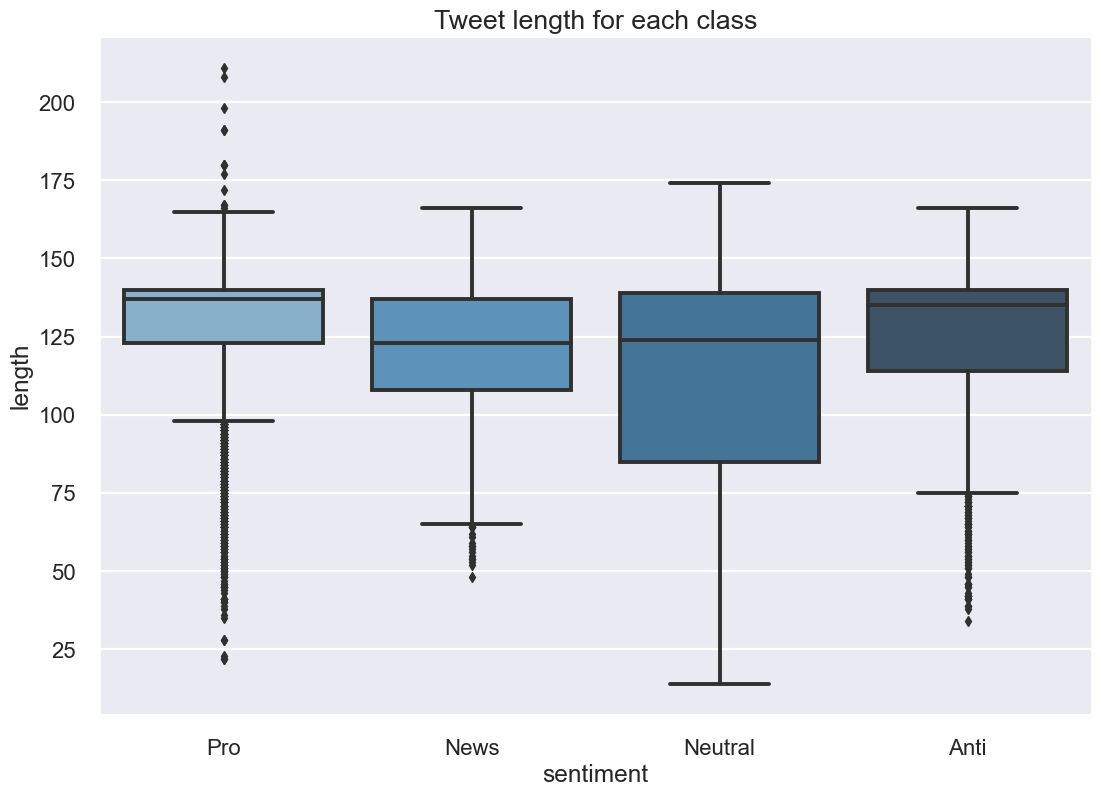

In [32]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x=df['sentiment'], y=df['length'], data=df, palette=("Blues_d"))
plt.title('Tweet length for each class')
plt.show()


From the plots below we can see that tweets that fall in the pro climate change class are generally longer and the shortest tweets belong to the anti climate change class. We also notice that neutral climate change tweets tend to have the most variability in tweet length.

#### Data Distribution

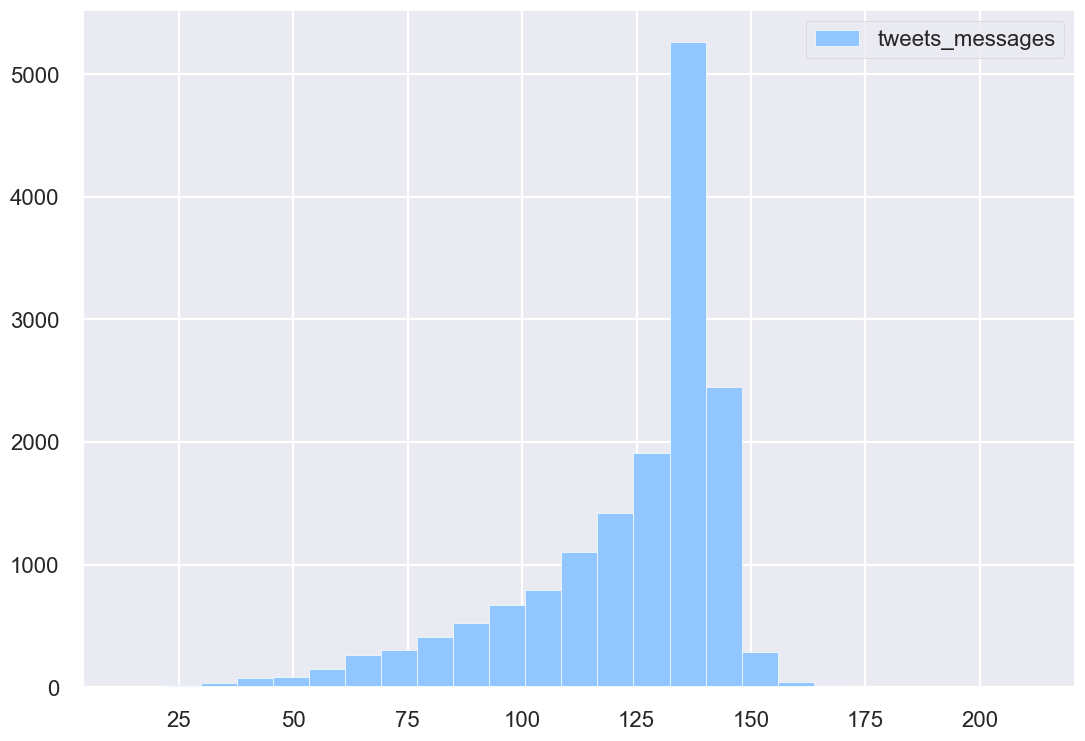

In [33]:
length_data = df['message'].str.len()

plt.hist(length_data, bins=25, label="tweets_messages")

plt.legend()
plt.show()

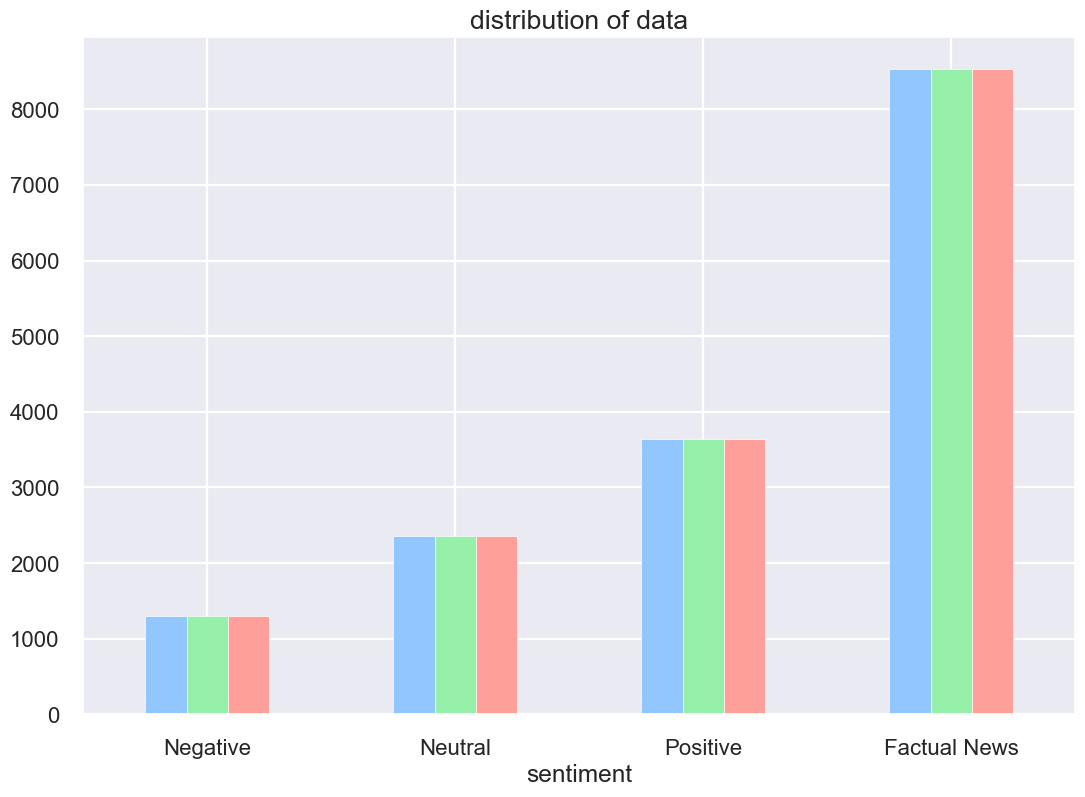

In [35]:
# plotting the distribution for dataset

ax = df.groupby('sentiment').count().plot(kind='bar', title='distribution of data', legend=False)
ax.set_xticklabels(['Negative','Neutral', 'Positive','Factual News'], rotation=0)

text, sentiment = list(df['message']), list(df['sentiment'])

#### Density Curve
A density curve is a curve on a graph that represents the distribution of values in a dataset. It gives us a good idea of the “shape” of a distribution, including whether or not a distribution has one or more “peaks” of frequently occurring values and whether or not the distribution is skewed to the left or the right.

<AxesSubplot:xlabel='message', ylabel='Density'>

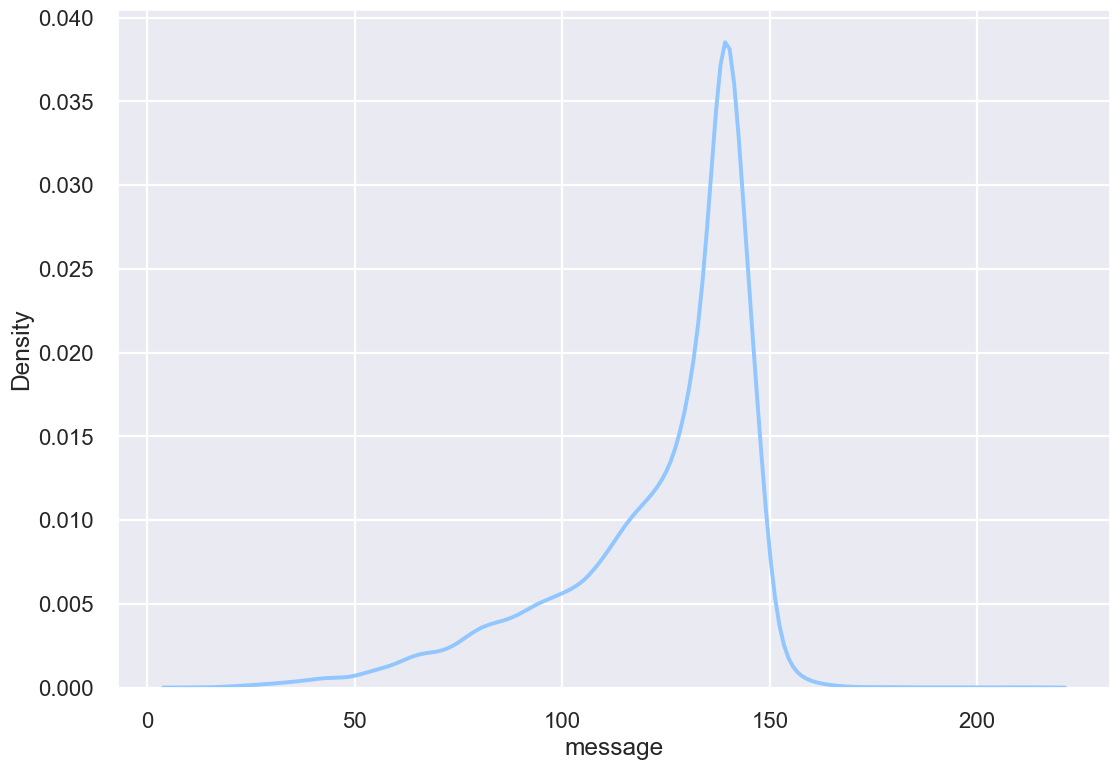

In [36]:
## Lenght of the Text using KDEplot
lenght = df["message"].str.len()
sns.kdeplot(lenght)

The curve is skewed to the left side of the distribution because that’s where the most values are located. It’s also lowest near the ends of the distribution because fewer message take on those values

### Word Cloud Visualization 

In [58]:
# Create word clouds for pro, anti, and neutral tweets
pro_wordcloud = WordCloud().generate(" ".join(df[df['sentiment'] == 'Pro']['message']))
anti_wordcloud = WordCloud().generate(" ".join(df[df['sentiment'] == 'Anti']['message']))
neutral_wordcloud = WordCloud().generate(" ".join(df[df['sentiment'] == 'Neutral']['message']))
news_wordcloud = WordCloud().generate(" ".join(df[df['sentiment'] == 'News']['message']))

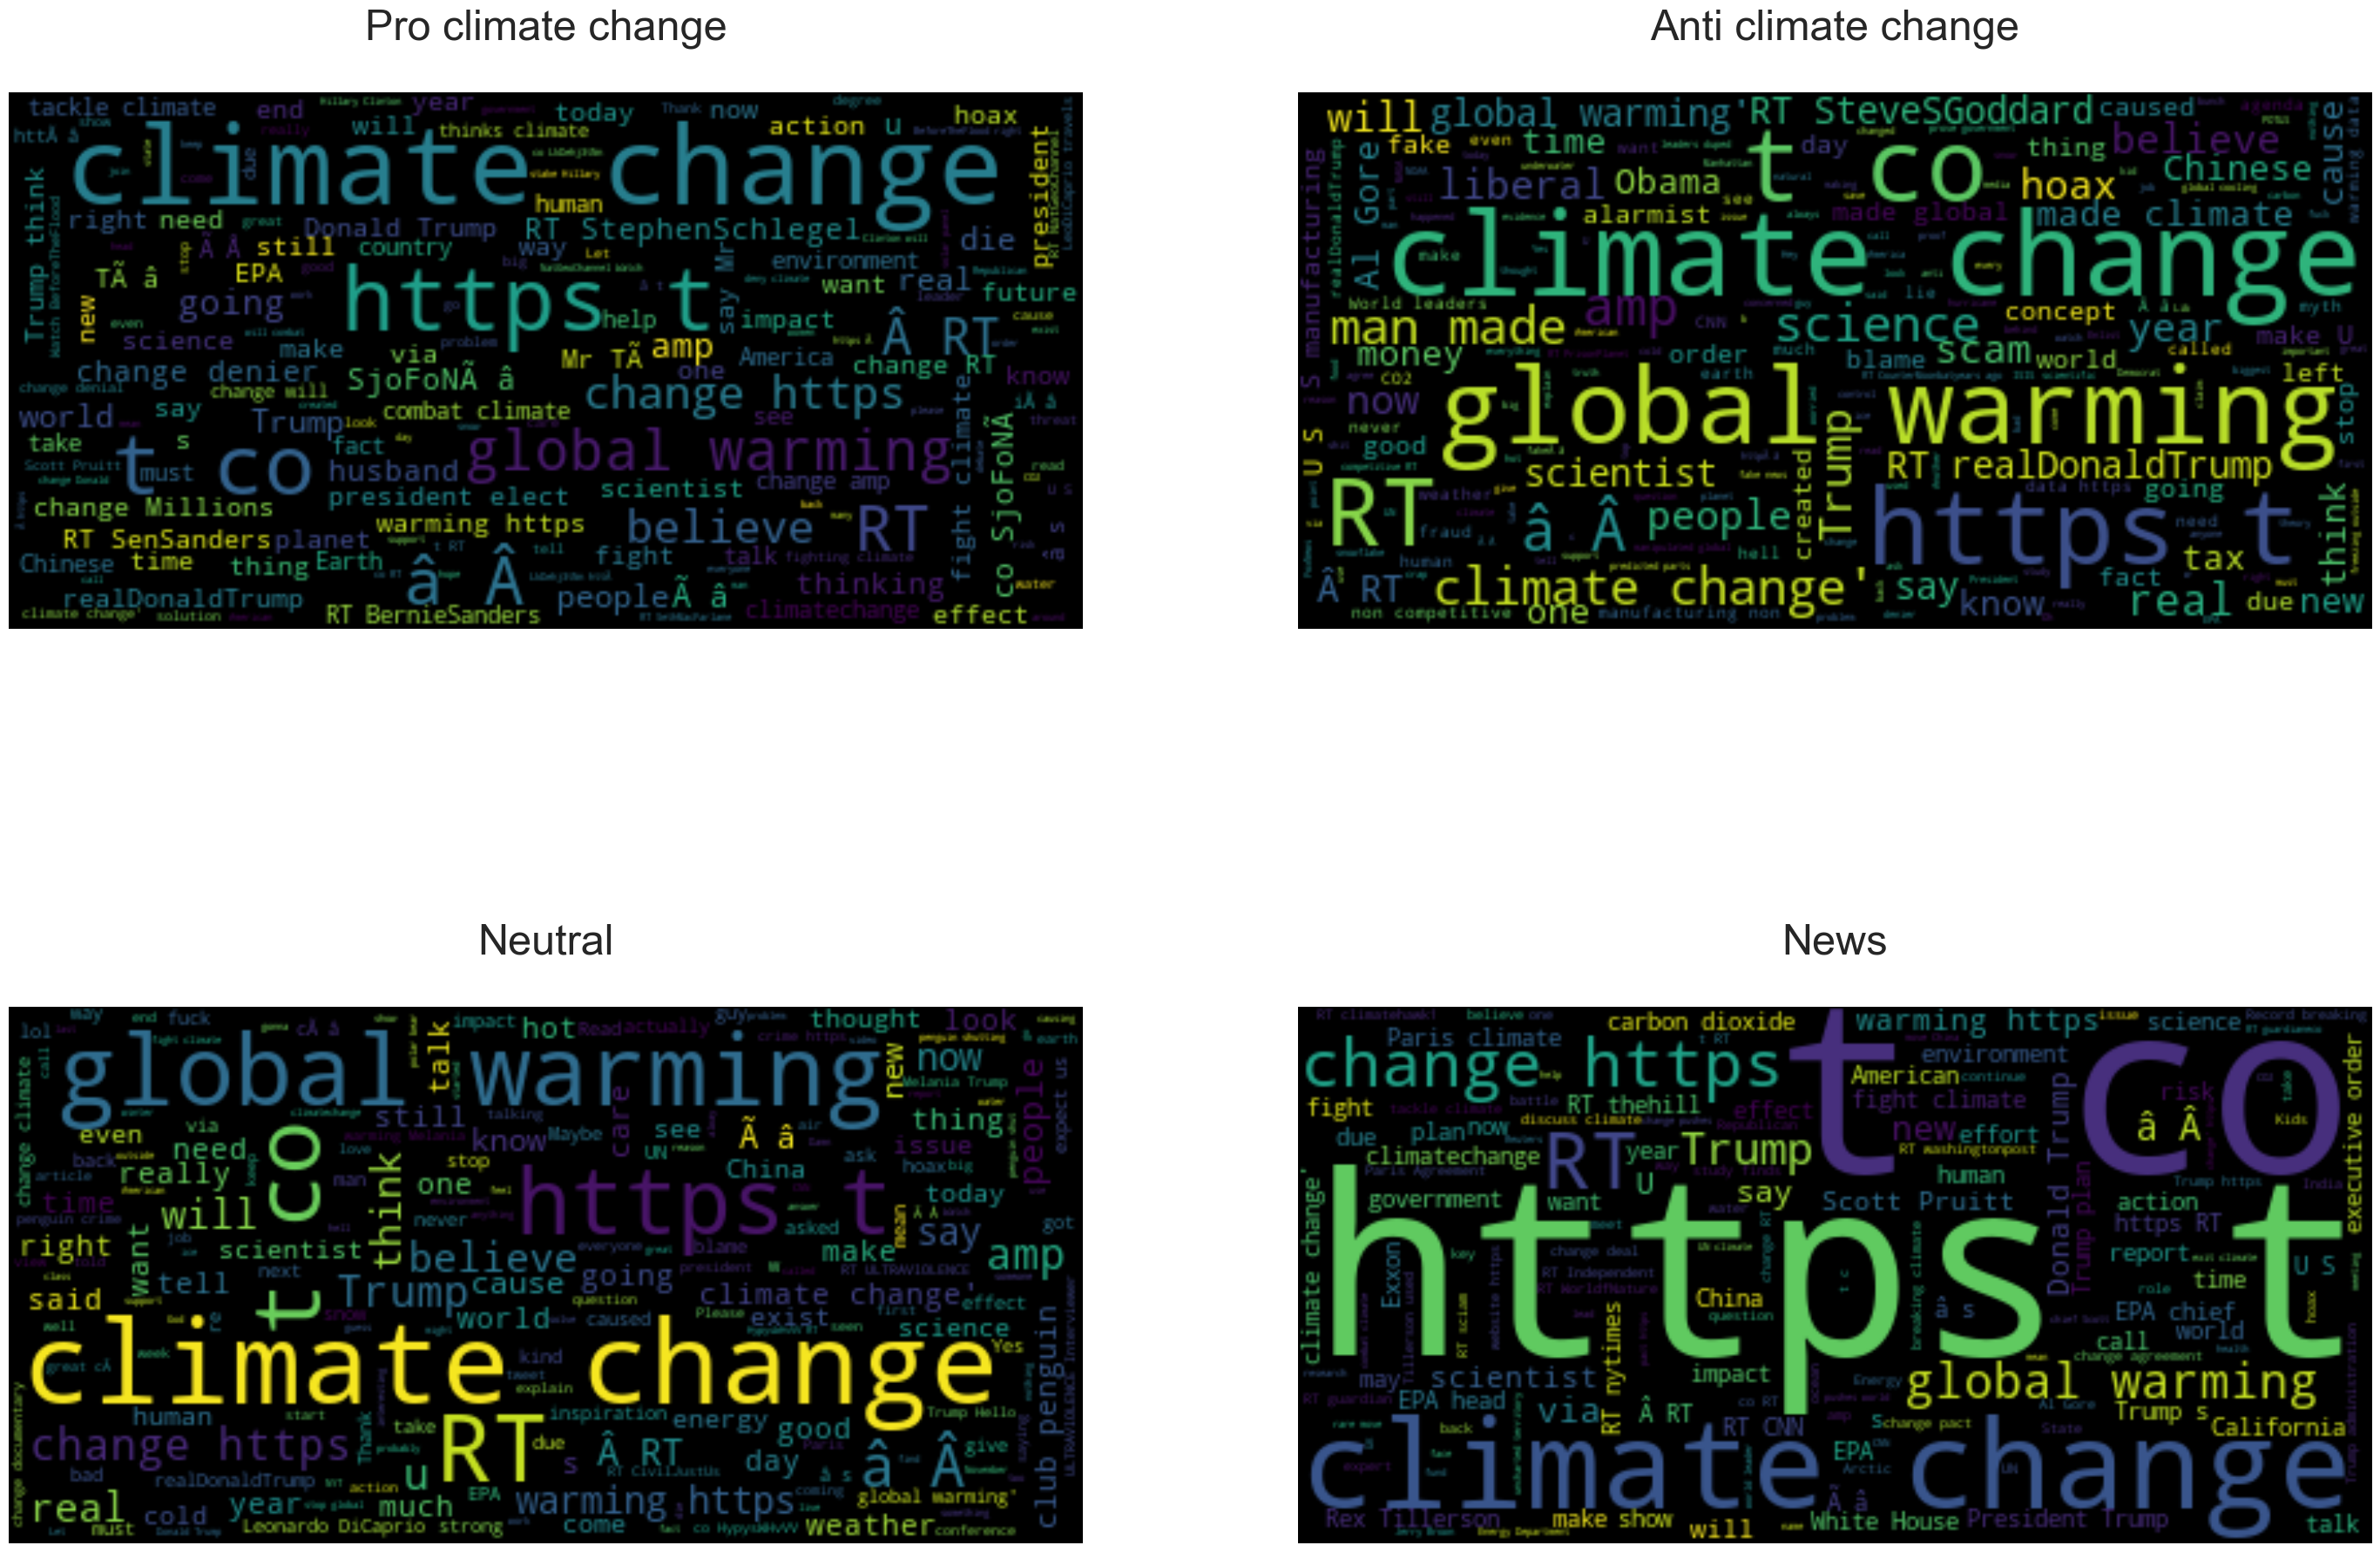

In [59]:
# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Pro climate change\n', fontsize=35)
axarr[0,1].set_title('Anti climate change\n', fontsize=35)
axarr[1,0].set_title('Neutral\n', fontsize=35)
axarr[1,1].set_title('News\n', fontsize=35)
#plt.tight_layout()
plt.show()

#print("Pro climate change buzzwords 20-25 shown here for clarity \n- The wordcloud doesn't seem to pick up on 'http'")
#display(pro_frequency.tail())

The Wordcloud Visualization displays the top 100 words from the message and sentiment columns.The size of the words is relative to the frequency of the word in the message column, meaning, the bigger the word the more frequently it appeared.


* ##### Tweets under Pro climate change

Common words in pro-sentiment include `climate change, https, RT,CO Believe, thinking`.

* ##### Tweets under Neutral 

Common words in neutral tweets include `global warming, climate change, Https,Rt, believe, think, real, people`. This could indicate uncerainty toward climate change validity or an apathetic inclination.

* ##### Tweets under Anti climate change

Common words in anti- sentiment include `Co, RT, Https, Trump, man made, global warming`. The common appearance of the words `liberal`,`was created`,`created by`,`fake`,`man made` and `crime` is an indication of a negative sentiment. Some of the common words shows a belief of conspiracy, words like `hoax, Chinese, manipulated`.

* ##### Ttweets under News

Common words news tweets are `Co, RT, Https, Trump, global warming, Scientists, researchers, ÈPA and reports`. This could reveal the sentiment that humans are the cause of climate change. The frequence of `reports` could be that many rely of the media to validate their beliefs.

There many retweets in the above dataframe. Retweets are repetions of an original post on twitter shared by different users. The former USA President, Donald `Trump`, appears often in all classes due to his administration's "controversial" stance on global warming, with Twitter being his source of communication during his presidency. 


### Hashtags

Hashtags have long been an important tool on Twitter for helping users organize and sort their tweets. They're a great way to indicate that your content is relevant to a certain topic and to get your tweets in front of an interested audience.

Considering this, we decided it might be insightful to see what the most frequent hashtags in each class are. This will help us gain a better understanding of what kind of information is being consumed and shared in each class.

In [71]:
def hashtag_extract(tweet):
    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
pro = hashtag_extract(df['message'][df['sentiment'] == 'Pro'])
anti = hashtag_extract(df['message'][df['sentiment'] == 'Anti'])
neutral = hashtag_extract(df['message'][df['sentiment'] == 'Neutral'])
news = hashtag_extract(df['message'][df['sentiment'] == 'News'])

pro.head()

hashtag  count
19          climate    187
24   BeforeTheFlood    129
68    climatechange     94
13  ImVotingBecause     62
4             COP22     59

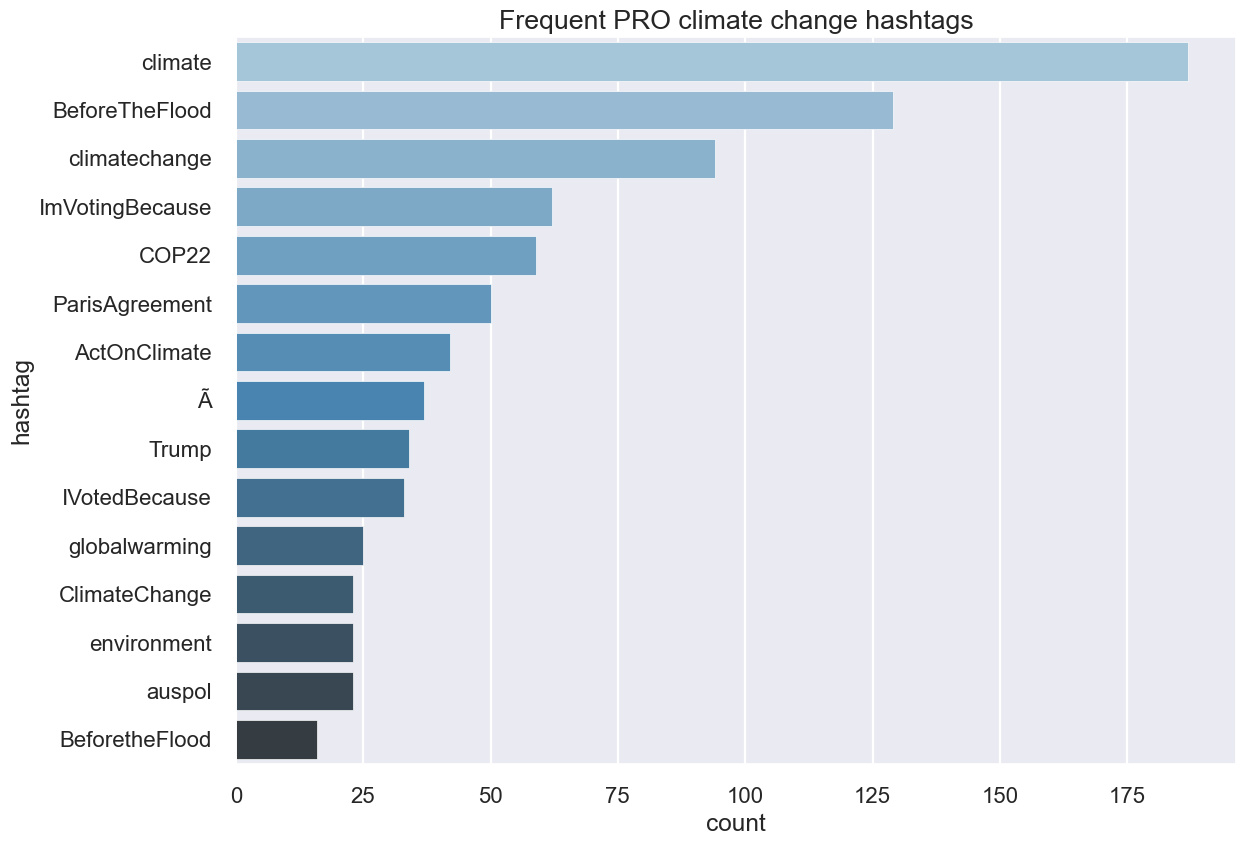

In [73]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'], palette=("Blues_d"))
plt.title('Frequent PRO climate change hashtags')
plt.tight_layout()

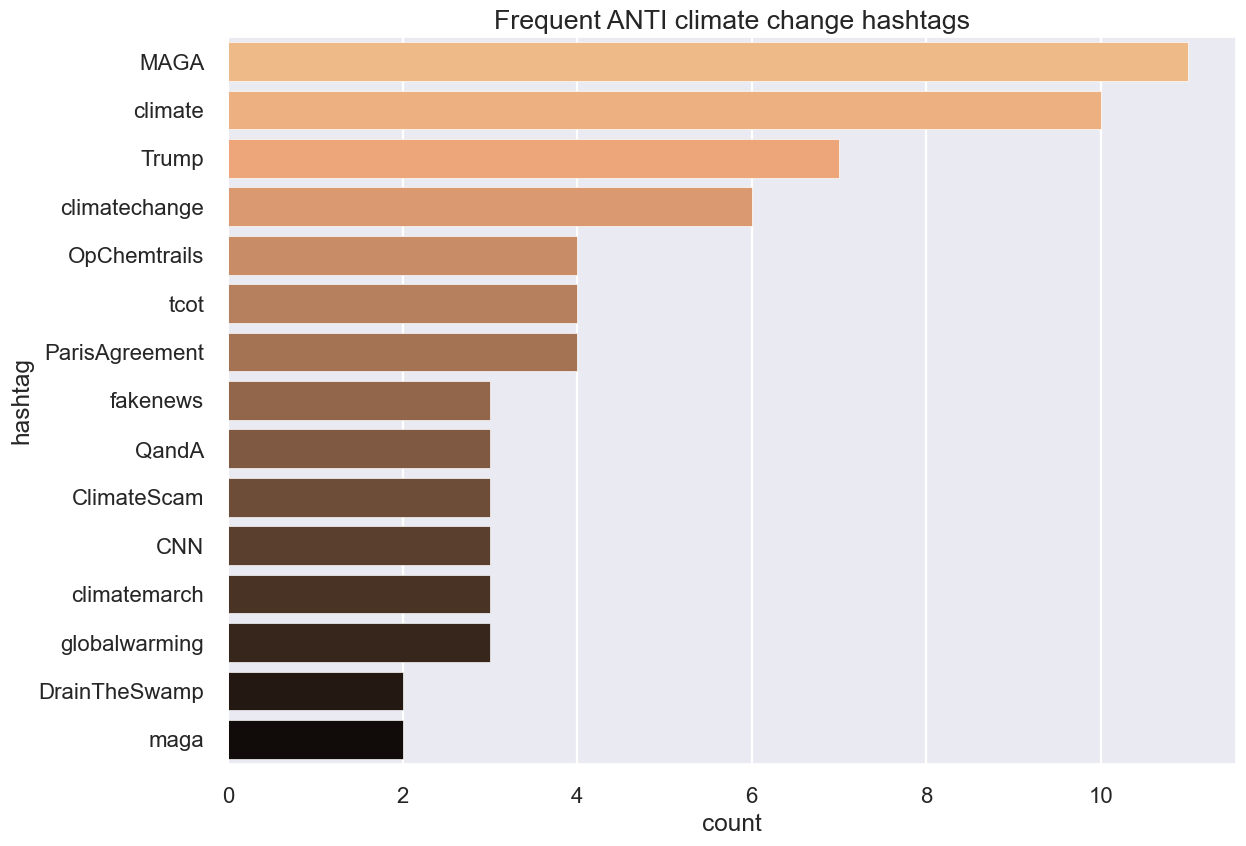

In [75]:
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'], palette=("copper_r"))
plt.title('Frequent ANTI climate change hashtags')
plt.tight_layout()

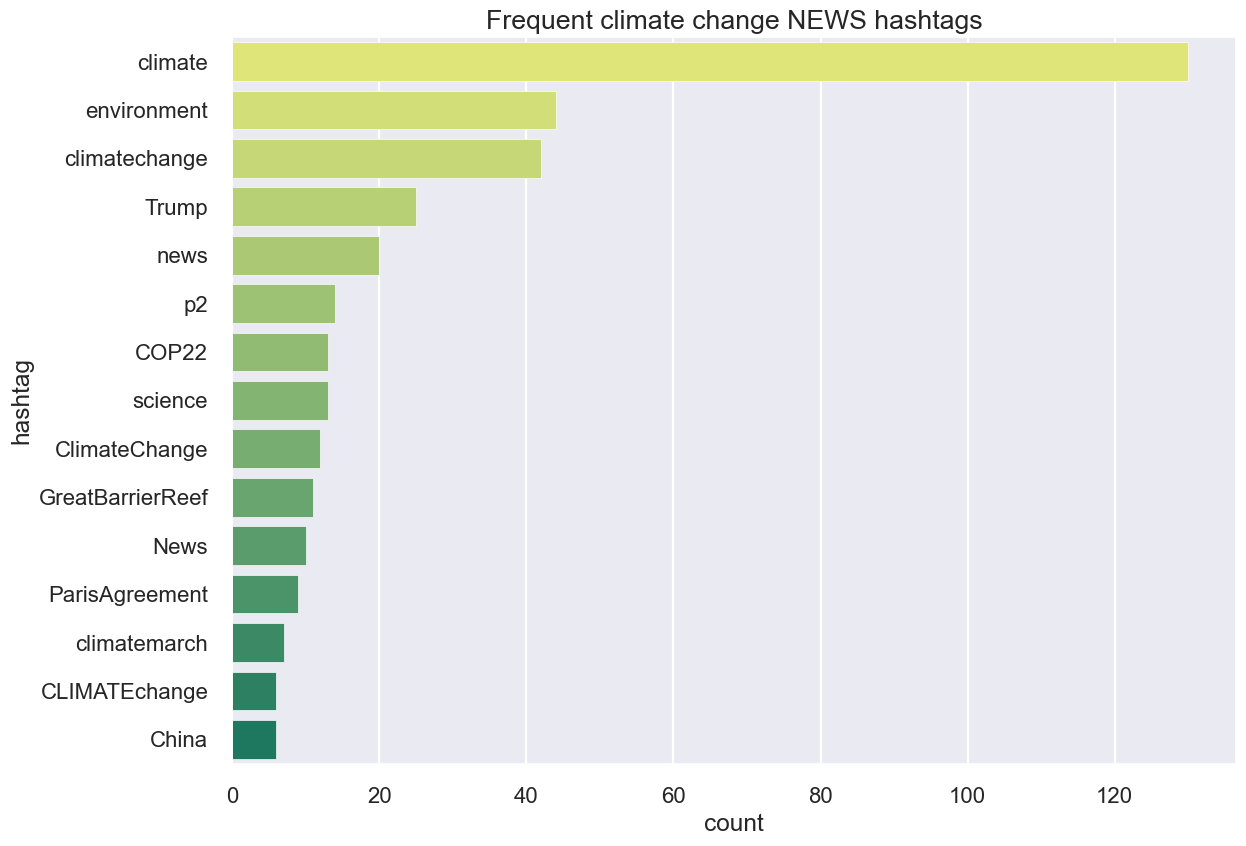

In [77]:
# Plot the frequent hastags for the news and neutral classes
sns.barplot(y=news['hashtag'], x=news['count'], palette=("summer_r"))
plt.title('Frequent climate change NEWS hashtags')
plt.tight_layout()

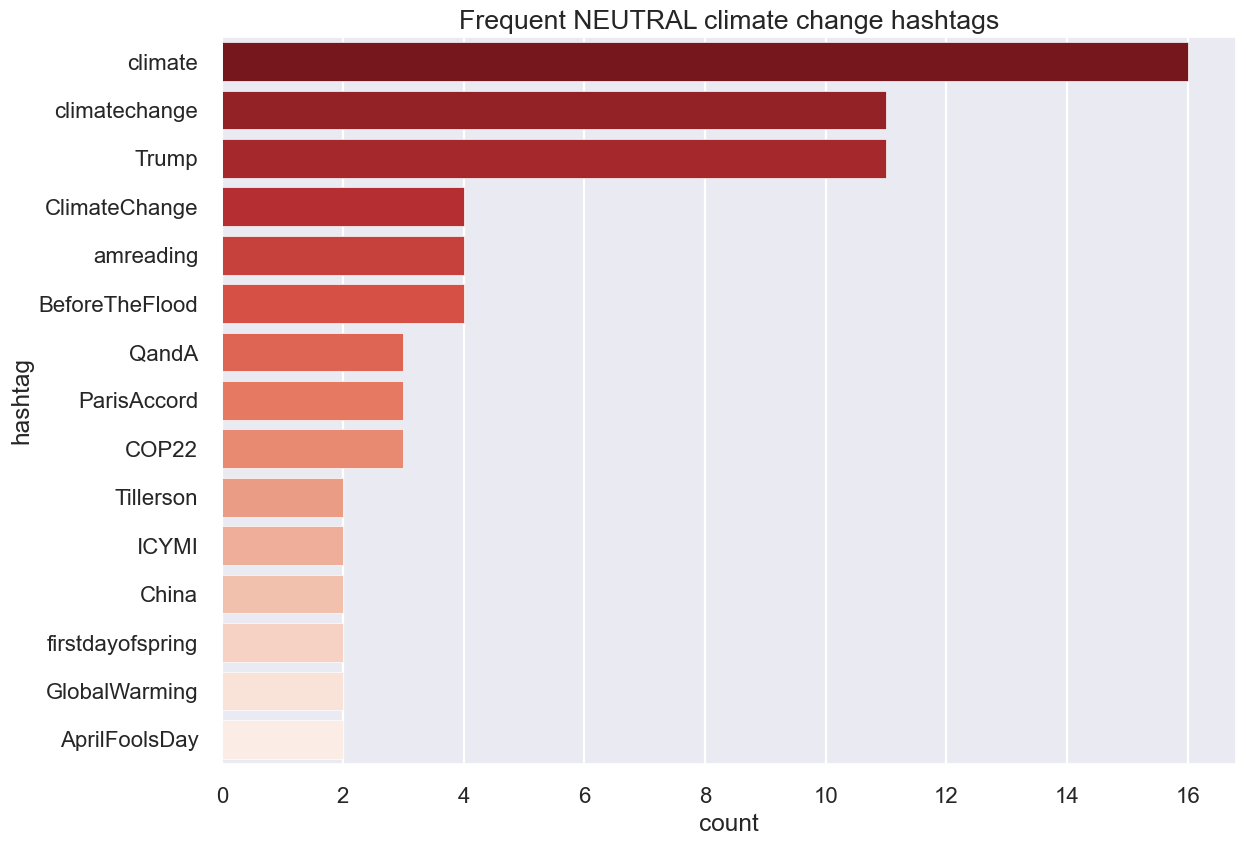

In [80]:
sns.barplot(y=neutral['hashtag'], x=neutral['count'], palette=("Reds_r"))
plt.title('Frequent NEUTRAL climate change hashtags')
plt.tight_layout()

The graphs show the most common hashtags.

* `Climate` is the most common hashtag in all the graphs with the exception of anti climate, however it is worth noting some of the hashtags `BeforeTheFlood`, `ParisAgreement`, `ActOnClimate`.  The count of these three hashtags could be an indication of how serious climate change believers view the topic. 

* The most common word on anti-climate change graph is `MAGA` which means "Make America Great Again", a slogan commonly associated with USA former President Donald Trump. Some of the other common hashtags included `Trump`, `fakenews`, `ClimateScam`. Another hashtag caught our attention `ParisAgreement` on how it would appear on the anti hashtags, upon further research we discovered that in order to "Make America Great Again" , Donald Trump believed the `ParisAgreement` was not beneficial to the United States and formally withdrew from it. 

## Data Pre-Processing

##### Data cleaning

Contractions need to be expanded into full text for standardization, this prevents the loss of words and meanings when punctuation is removed. This improves the machine's ability to read and interpret the data. A computer does not understand that contractions are abbreveations, for example it will consider `couldn't` and `could not` as two words that are completely different and will not recognise that the have same meaning.

Removing `hashtags, symbols, numbers and users` as it add no value to the data. Lowercasing all text data is very effective for consistency as models are case sensitive 

def TweetCleaner(tweet):
    # Convert everything to lowercase
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove that funny diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

# Clean the tweets in the message column
df['message'] = df['message'].apply(TweetCleaner)
df['message'] = df['message'].apply(TweetCleaner)

df.head()

#### Parts of speech tagging and lemmatization
In this step we start by determining the length of each tweet and storing this information in a new column. We then tokenize the tweets before performing POS tagging on each word followed by lemmatization.

In lemmatization, we reduce the word into dictionary root form. For instance "cats" is converted into "cat". Lemmatization is done in order to avoid creating features that are semantically similar but syntactically different. Lemmatization is preferred over stemming since stemming is a crude method for cataloging related words; it essentially chops off letters from the end until the stem is reached. This works fairly well in most cases, but unfortunately English has many exceptions where a more sophisticated process is required

In [83]:
def lemma(df):
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

    def get_wordnet_pos(tag):

        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB

        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lemma(df)
df.head()

sentiment                                            message  tweetid  \
0       Pro  polyscimajor epa chief doesn t think carbon di...   625221   
1       Pro  it s not like we lack evidence of anthropogeni...   126103   
2      News  rt researchers say we have three years to act ...   698562   
3       Pro  wired was a pivotal year in the war on climate...   573736   
4       Pro  rt it s and a racist sexist climate change den...   466954   

   length                                          tokenized  \
0     102  [polyscimajor, epa, chief, doesn, t, think, ca...   
1      62  [it, s, not, like, we, lack, evidence, of, ant...   
2      86  [rt, researchers, say, we, have, three, years,...   
3      54  [wired, was, a, pivotal, year, in, the, war, o...   
4      81  [rt, it, s, and, a, racist, sexist, climate, c...   

                                            pos_tags  \
0  [(polyscimajor, a), (epa, n), (chief, n), (doe...   
1  [(it, n), (s, v), (not, r), (like, n), (we, n)...   
2  [(rt, n), (researchers, n), (say, v), (we, n),...   
3  [(wired, v), (was, v), (a, n), (pivotal, a), (...   
4  [(rt, v), (it, n), (s, n), (and, n), (a, n), (...   

                                          lemmatized  
0  polyscimajor epa chief doesn t think carbon di...  
1  it s not like we lack evidence of anthropogeni...  
2  rt researcher say we have three year to act on...  
3  wire be a pivotal year in the war on climate c...  
4  rt it s and a racist sexist climate change den...